# Data Preparation for Flood Filling Unet Training

In this file a dataset is created to train a flood filling 3D Unet with. This task encompasses the following steps:

- Open Tiff Stacks / h5 or n5 files
- data exploration and visualization
- sample mining
- creation of training examples
    - save image chunks of appropriate size
    - save a seed location to initialize the segmentation canvas

In [ ]:
import numpy as np 
import os, sys
import matplotlib.pyplot as plt
from importlib import reload
from scipy.stats import linregress

import h5py, z5py

sys.path.append('../tools/')
import tilingStrategy, Dataset3D, visualization

In [ ]:
reload(visualization)
reload(Dataset3D)
reload(tilingStrategy)

## Open the file and load the potentially large image volume

In [ ]:
# Open an image volume
image_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_image_0724.h5"
image_h5 = h5py.File(image_path, mode='r+') # Open h5 file with read / write access
print(image_h5['t0'].keys()) # Show Groups (Folders) in root Group of the h5 archive

image = image_h5['t0/channel0']

mask_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_mask_0724.h5"
mask_h5 = h5py.File(mask_path, mode='r') # Open h5 file with read / write access

mask = mask_h5['t0/channel0']
print('loaded image with shape {}\nloaded mask with shape {}'.format(image.shape, mask.shape))

## Volume subdivision

One training example should allow the ffunet to make a step into each direction. Therefore we need to cut out cubes of (input_size + 2*step_size) length.

In [ ]:
# Define geometry of example subvolumes
input_shape = (220,220,220)
delta = (8,8,8)
example_shape = tuple([i+2*d for i,d in zip(input_shape,delta)])

# Use the output shape to tile the volume, choose the example shape as input shape so that Dataset 3D stores large enough areas around the choosen locations
tiler = tilingStrategy.UnetTiler3D(image=image, mask=mask, output_shape=(132,132,132), input_shape=example_shape)
print(tiler.shape)
# since input = ouput shape there is no padding

In [ ]:
indices = Dataset3D.getRandomIndices(tiler, n_samples=300) # sample random tiles from the image volume

In [ ]:
# Plot the distribution of the mean signal strength in our samples
signal_strengths = Dataset3D.getMeanSignalStrengths(tiler, indices) # With about 17% of samples containing the neuron this should be enough sampling to collect 50 samples for the dataset
_ = plt.hist(signal_strengths, bins=30)
plt.title('Mean signal strength in samples')
plt.xlabel('mean signal strength')
plt.ylabel('count')
plt.show()

In [ ]:
print('{} elements above 140'.format(np.count_nonzero([s > 140 for s in signal_strengths])))

In [ ]:
# Prepare a dataset with thresholded Sampling:
thresholded = Dataset3D.thresholdedSampling(indices,signal_strengths,threshold=149,n_samples=50,object_ratio=0.9)

### Thresholding by proportion of masked volume (not background) in the sample mask
Alternatively, since a dataset is generated from labeled data, we can use the mean proportion of the masked volume to identify interesting samples

In [ ]:
mask_proportions = Dataset3D.sampleMaskProportion(tiler, indices)
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(mask_proportions, bins=30)
plt.title('Mean mask proportion in sample masks')
plt.xlabel('mean mask proportion')
plt.ylabel('count')
plt.show()

In [ ]:
print('{} elements above 0.001'.format(np.count_nonzero([s > 0.001 for s in mask_proportions])))
print('{} elements exactly zero'.format(np.count_nonzero([s == 0 for s in mask_proportions  ])))

In [9]:
# Prepare a detaset with mask thresholded sampling
mask_thresholded = Dataset3D.thresholdedSampling(indices, mask_proportions, threshold=0, above_threshold_ratio=1, n_samples=50)

### Exploring the relation between Signal strength and mask Proportion in the tiles

Divide the tiles into groups with a specific proportion of the mask between 0 and the maximum proportion. Create a database by sampling each class with equal probability

In [ ]:
# visualiz ethe relation between mean signal strength and mask proportion
plt.figure()
plt.scatter(signal_strengths, mask_proportions)
plt.xlabel('mean signal strength')
plt.ylabel('mean mask proportion')
plt.title('Relation of mask proportion and signal strength in randomly sampled tiles')


In [ ]:
ss_normalized = np.divide(np.subtract(signal_strengths, np.mean(signal_strengths)), np.std(signal_strengths))
mp_normalized = np.divide(np.subtract(mask_proportions, np.mean(mask_proportions)), np.std(mask_proportions))
plt.figure()
plt.scatter(ss_normalized,mp_normalized)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('normalized signal strength')
plt.ylabel('normalized mask proportion')
plt.title('Covariance of mask proportion and signal strength')

In [ ]:
# calculate the number of samples in each quadrant of the plot
# this divides tiles into categories with above/below average mask proportion / signal strength
aa, ba, bb, ab = (
    np.count_nonzero( np.all([ss_normalized > 0 , mp_normalized > 0], axis=0) ),
    np.count_nonzero( np.all([ss_normalized < 0 , mp_normalized > 0], axis=0) ),
    np.count_nonzero( np.all([ss_normalized < 0 , mp_normalized < 0], axis=0) ),
    np.count_nonzero( np.all([ss_normalized > 0 , mp_normalized < 0], axis=0) ))
print('{}   {}\n{}  {}'.format(ba, aa, bb, ab))

In [ ]:
# use mask proportion as input to predict signal strength. If points are significantly above predicted line, they contain bright blobs
slope, intercept, r_value, p_value, std_err = linregress(x=mask_proportions,y=signal_strengths)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(mask_proportions, signal_strengths, 'o', label='original data')
plt.plot(mask_proportions, intercept + np.multiply(slope,mask_proportions), 'r', label='fitted line')
plt.legend()
plt.show()

In [ ]:
residuals = signal_strengths - (intercept + np.multiply(slope, mask_proportions))
res_normalized = np.divide(np.subtract(residuals, np.mean(residuals)), np.std(residuals))
_ = plt.hist(residuals, bins=50)
plt.title('Deviations from linear relationship between mask proportion and signal strength')
plt.xlabel('residual mean signal strength')
plt.ylabel('count')
plt.show()

In [ ]:
# Visualize tiles where the signal strength is significantly lower than expected
reload(visualization)
res_below = [indices[i] for i in range(len(indices)) if res_normalized[i] < -0.5]
res_above = [indices[i] for i in range(len(indices)) if res_normalized[i] > 0.5]

for i in res_below[:5]:
    visualization.showProjections([tiler.getSlice(i),tiler.getMaskSlice(i)], axis=0, cmap='Greys', title='Sample ' + str(i) + ' is below predicted signal intensity')
for i in res_above[:]:
    visualization.showProjections([tiler.getSlice(i),tiler.getMaskSlice(i)], axis=0, cmap='Greys', title='Sample ' + str(i) + ' is above predicted signal intensity')

In [ ]:
# Visualize where the samples with greater than expected signal intensity come from
res_above_dist = np.zeros(tiler.shape)
for sample in res_above:
    coords = tiler.tiling.indexToCoordinates(sample)
    res_above_dist[coords] = 1 
plt.imshow(np.sum(res_above_dist,axis=0))

In [ ]:
# Prepare a completely random sample from the dataset (baseline comparison):
random = np.random.choice(indices, size=5)
for i in random:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

In [ ]:
# Visualize the mean mean signal thresholded sampling
for i in thresholded[:5]:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

In [ ]:
# Visualize the mask thresholded sampling
for i in mask_thresholded[:5]:
    visualization.showZSlices(tiler.getSlice(i), mode='h5')

In [ ]:
# Visualize which regions were sampled from the tiling, verify overlap with dataset content
thresholded_dist = np.zeros((4,16,16))
for sample in thresholded:
    coords = tiler._indexToCoordinates(sample)
    thresholded_dist[coords] = 1

mask_thresholded_dist = np.zeros((4,16,16))
for sample in mask_thresholded:
    coords = tiler._indexToCoordinates(sample)
    mask_thresholded_dist[coords] = 1 

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.gca().set_title('Z Projection of image volume')
plt.imshow(np.sum(np.clip(mask,0,1), axis=0), cmap='gray')
plt.subplot(1,3,2)
plt.gca().set_title('Z Projection of samples taken by thresholding')
plt.imshow(np.sum(thresholded_dist, axis=0))
plt.subplot(1,3,3)
plt.gca().set_title('Z Projection of samples taken by mask thresholding')
plt.imshow(np.sum(mask_thresholded_dist, axis=0))

## Create a dataset

Use the Dataset3D class to create a new dataset or append to an existing one.
Datasets contain named entries that hold an input image and it's corresponding mask together with some metadata.

In [10]:
reload(Dataset3D)
dataset = Dataset3D.Dataset(dataset_path='C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\ffn_dataset.h5')
dataset.keys()

<KeysViewHDF5 []>

In [11]:
dataset.add_tiles(tiler, mask_thresholded,
    cropMask=False,
    metadata={'source_image':image_path, 'preprocessing':'None', 'date':'20200825'})

Tiles added: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


In [12]:
# collect the mask proportion of all samples that were picked for the dataset
mask_thresholded_object_ratio = [mask_proportions[i] for i in range(len(mask_proportions)) if indices[i] in mask_thresholded]

# Calculate the ratio of neuron to background pixels in the training set so that we can adjust class weights during training

object_ratio = np.mean(mask_thresholded_object_ratio) # mean = sum / tot_pixels = the proportion of class label 1
object_weight = 1 / object_ratio # devide by proportion of cases to factor out imbalance of case numbers
background_weight = 1 / (1-object_ratio)
print('class weights background (0) * {:.3f} objects (1) * {:.3f}'.format(background_weight, object_weight))

# Save the calculated class weights as dataset attributes
dataset.setAttribute('background_weight',background_weight)
dataset.setAttribute('object_weight',object_weight)

class weights background (0) * 1.023 objects (1) * 44.079


In [14]:
dataset.setAttribute('stepsize', delta)
dataset.setAttribute('input_shape', input_shape)
dataset.setAttribute('comment','This dataset is intended for flood filling network training. Each training example allows for a grid of 3x3x3 evaluations. Each example is guaranteed to contain the object in the central tile')

In [15]:
# Close the dataset
print(dataset.keys())
dataset.close()

<KeysViewHDF5 ['122', '139', '209', '242', '244', '256', '258', '259', '275', '300', '312', '321', '327', '329', '342', '344', '348', '358', '364', '394', '422', '437', '438', '456', '470', '473', '482', '486', '571', '572', '576', '588', '600', '625', '630', '647', '673', '694', '709', '721', '736', '737', '778', '810', '897', '900', '913', '914', '929', '930']>


## Inspect a prepared dataset

In [16]:
# Open the dataset
reload(Dataset3D)
dataset = Dataset3D.Dataset('C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\ffn_dataset.h5')

Opened dataset with 50 preexisting items. Overwriting items with the same name.


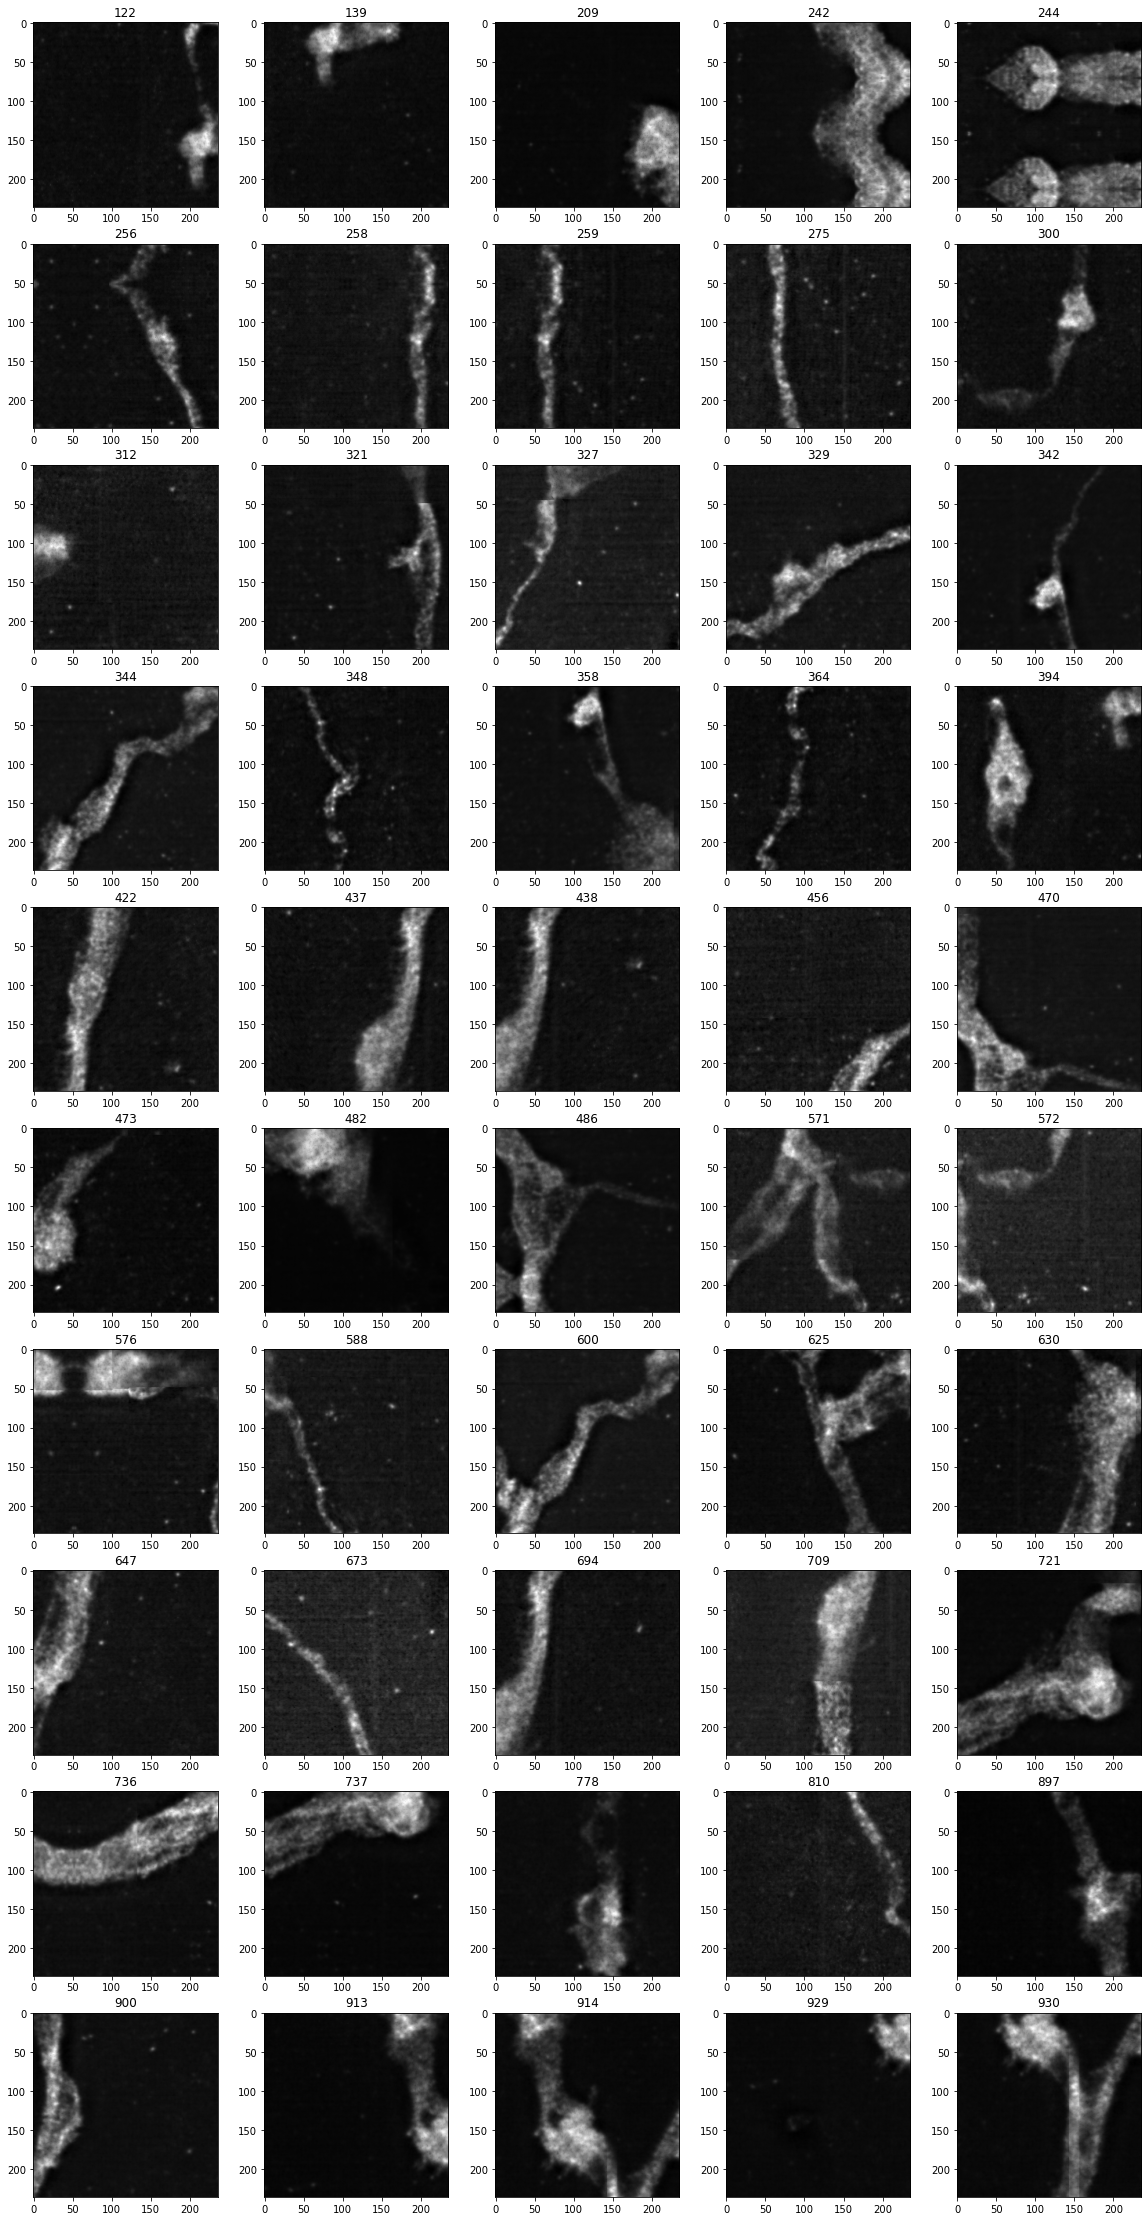

In [17]:
# Visualize the content of a generated dataset
plt.figure(figsize=(20,40))
samples = list(dataset.keys())
for i, sample in enumerate(samples):
    plt.subplot(10,5,i+1)
    plt.gca().set_title(sample)
    plt.imshow(np.sum(dataset.get(sample)[0], axis=0), cmap='gray')

In [18]:
bad_entries = [244,242]
[dataset.delete(entry) for entry in bad_entries]

[None, None]

In [19]:
dataset.close()